In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
import torch
import random
from typing import List, Dict
from utils import ProtoNet
import torch.nn.functional as F
from tqdm import tqdm

You can download dataset [here](https://docs.google.com/uc?export=download&id=1CgJhLEqTLalfQYz_L-HKMSC_akRBPYFs)

In [2]:
# !sh download.sh

--2022-11-02 20:19:31--  https://docs.google.com/uc?export=download&confirm=&id=1CgJhLEqTLalfQYz_L-HKMSC_akRBPYFs
Resolving docs.google.com (docs.google.com)... 142.250.66.142, 2404:6800:4005:81c::200e
Connecting to docs.google.com (docs.google.com)|142.250.66.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/547i40sum71n09ssjpdefijq0iquhsnl/1667387925000/13359194491851522081/*/1CgJhLEqTLalfQYz_L-HKMSC_akRBPYFs?e=download&uuid=399388d8-0b71-4443-a1f3-d5cb8b7fae07 [following]
--2022-11-02 20:19:31--  https://doc-0s-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/547i40sum71n09ssjpdefijq0iquhsnl/1667387925000/13359194491851522081/*/1CgJhLEqTLalfQYz_L-HKMSC_akRBPYFs?e=download&uuid=399388d8-0b71-4443-a1f3-d5cb8b7fae07
Resolving doc-0s-70-docs.googleusercontent.com (doc-0s-70-docs.googleusercontent.com)... 142.251.220.1, 2404:6800:400

In [4]:
# !unzip BIRDS-450-FS.zip -d BIRDS-450-FS

Archive:  BIRDS-450-FS.zip
  inflating: BIRDS-450-FS/ABBOTTS BABBLER/1.jpg  
  inflating: BIRDS-450-FS/ABBOTTS BABBLER/2.jpg  
  inflating: BIRDS-450-FS/ABBOTTS BABBLER/3.jpg  
  inflating: BIRDS-450-FS/ABBOTTS BABBLER/4.jpg  
  inflating: BIRDS-450-FS/ABBOTTS BABBLER/5.jpg  
  inflating: BIRDS-450-FS/ABBOTTS BOOBY/1.jpg  
  inflating: BIRDS-450-FS/ABBOTTS BOOBY/2.jpg  
  inflating: BIRDS-450-FS/ABBOTTS BOOBY/3.jpg  
  inflating: BIRDS-450-FS/ABBOTTS BOOBY/4.jpg  
  inflating: BIRDS-450-FS/ABBOTTS BOOBY/5.jpg  
  inflating: BIRDS-450-FS/ABYSSINIAN GROUND HORNBILL/1.jpg  
  inflating: BIRDS-450-FS/ABYSSINIAN GROUND HORNBILL/2.jpg  
  inflating: BIRDS-450-FS/ABYSSINIAN GROUND HORNBILL/3.jpg  
  inflating: BIRDS-450-FS/ABYSSINIAN GROUND HORNBILL/4.jpg  
  inflating: BIRDS-450-FS/ABYSSINIAN GROUND HORNBILL/5.jpg  
  inflating: BIRDS-450-FS/AFRICAN CROWNED CRANE/1.jpg  
  inflating: BIRDS-450-FS/AFRICAN CROWNED CRANE/2.jpg  
  inflating: BIRDS-450-FS/AFRICAN CROWNED CRANE/3.jpg  
  inflatin

In [2]:
# args
num_way: int = 5
num_spt: int = 4
num_qry: int = 1
lr: float = 0.01
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def img2arr(image_path: str, return_type="torch", size: int = 32):
    lilac_roller = Image.open(image_path)
    lilac_roller = lilac_roller.resize(size=(32, 32))
    lilac_roller = np.asarray(lilac_roller)/255
    lilac_roller = lilac_roller.transpose(-1, 0, 1)
    if return_type == "torch":
        return torch.from_numpy(lilac_roller).to(torch.float32)
    return lilac_roller

In [4]:
images =  {
    p.name : [ img2arr(image_path) for image_path in p.glob("*")] 
    for p in Path("./BIRDS-450-FS").glob("*")
}
labels = list(images.keys())

In [5]:
random.shuffle(labels)

train_labels = labels[:int(len(labels) * 0.8)]
test_labels = labels[int(len(labels) * 0.8):]

In [6]:
def sample_data(
    num_way: int, 
    num_spt: int, 
    labels, 
    device,
    num_qry: int = 1,
):
    classes = random.sample(labels, num_way)
    X_spt: List[torch.Tensor] = []
    X_qry: List[torch.Tensor] = []
    y_spt: List[int] = []
    y_qry: List[int] = []

    for i, cls in enumerate(classes):
        image_tensors = random.sample(images[cls], num_spt+num_qry)
        X_spt += image_tensors[:num_spt]
        X_qry += image_tensors[num_spt:]
        y_spt += [i] * num_spt
        y_qry += [i] * num_qry

    X_spt = torch.stack(X_spt).to(device=device)
    X_qry = torch.stack(X_qry).to(device=device)
    y_spt = torch.tensor(y_spt).to(device=device)
    y_qry = torch.tensor(y_qry).to(device=device)

    return (X_spt, X_qry, y_spt, y_qry), classes.copy()


In [7]:
plt.style.use("dark_background")
def visualize_batch(X_spt, X_qry, y_spt, y_qry, id2cls):
    num_way: int = torch.unique(y_spt).size(0)
    num_spt: int = y_spt.size(0)//num_way
    num_qry: int = y_qry.size(0)//num_way

    fig, axes = plt.subplots(
        ncols=num_way, 
        nrows=num_spt,
        figsize=( num_way*3, 1 + num_spt*3,),
        subplot_kw={
            "xticks": [],
            "yticks": []
        }
    )
    fig.suptitle("Support Set", fontsize=20)
    axes = axes.T.reshape(-1)
    for i, ax in enumerate(axes):
        ax.imshow(X_spt[i,:,:,:].permute(1, 2, 0) )
        ax.set_title(id2cls[y_spt[i]])

    fig, axes = plt.subplots(
        ncols=num_way, 
        nrows=num_qry,
        figsize=( num_way*3, 1 + num_qry*3),
        subplot_kw={
            "xticks": [],
            "yticks": []
        }
    )
    fig.suptitle("Query Set", fontsize=20)
    axes = axes.T.reshape(-1)
    for i, ax in enumerate(axes):
        ax.imshow(X_qry[i,:,:,:].permute(1, 2, 0))
        ax.set_title(id2cls[y_qry[i]])

    plt.show()



In [8]:
def get_loss(encoder: torch.nn.Module, batch: tuple, num_way: int, num_spt: int, num_qry: int = 1):
    X_spt, X_qry, y_spt, y_qry = batch
    # create prototypes
    X_emb_spt = encoder(X_spt)
    prototypes = torch.stack([prototype.mean(dim=0) for prototype in X_emb_spt.split(num_spt, dim=0)])

    # create l2 dist, logits, and loss
    X_emb_qry = encoder(X_qry)
    emb_size = X_emb_qry.size(-1)
    prototypes = prototypes.unsqueeze(0).expand(num_qry*num_way, num_way, emb_size ).reshape(num_way*num_qry*num_way, emb_size)
    X_emb_qry = X_emb_qry.unsqueeze(1).expand(num_way*num_qry, num_way, 256).reshape(num_way*num_qry*num_way, emb_size)
    l2dist = torch.sum((prototypes - X_emb_qry)**2, dim=-1).reshape(num_way, num_qry*num_way)
    logits = -l2dist
    loss = F.cross_entropy(logits, y_qry)
    logits = logits.cpu().detach()
    preds = logits.argmax(dim=-1)
    return loss, logits.numpy(), preds.eq(y_qry).sum().item()

In [9]:
encoder = ProtoNet(x_dim=3).to(device=device)
optimizer = torch.optim.SGD(params=encoder.parameters(), lr=lr)

In [11]:
encoder.train()

rec_losses = []
rec_acc = []

losses = 0
total_num_correct = 0
for i in range(5000):
    batch, id2cls = sample_data(num_way, num_spt, train_labels, device, num_qry)
    loss, logits, temp_num_correct = get_loss(encoder, batch, num_way, num_spt, num_qry)
    temp_loss = loss.item()
    total_num_correct += temp_num_correct
    losses += temp_loss
    if i % 100 == 99:
        rec_losses.append(losses/100)
        rec_acc.append(total_num_correct/(100*num_qry*num_way))
        print(f"current loss: {rec_losses[-1]}")
        print(f"current acc: {rec_acc[-1]:.3f}")
        losses = 0
        total_num_correct = 0

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

current loss: 3.8738581400644034
current acc: 0.606
current loss: 1.026535715535283
current acc: 0.656
current loss: 0.7201098989136517
current acc: 0.750
current loss: 0.6846440107747912
current acc: 0.754
current loss: 0.645891566351056
current acc: 0.736
current loss: 0.6399176172539591
current acc: 0.760
current loss: 0.5328385738376528
current acc: 0.778
current loss: 0.5999018318019808
current acc: 0.772
current loss: 0.5982278951350599
current acc: 0.786
current loss: 0.49238394954707476
current acc: 0.824
current loss: 0.42307832177728416
current acc: 0.846
current loss: 0.47670960212126373
current acc: 0.814
current loss: 0.44829358959570526
current acc: 0.824
current loss: 0.40625503098592164
current acc: 0.852
current loss: 0.35505923139862716
current acc: 0.868
current loss: 0.38223990163533017
current acc: 0.864
current loss: 0.3348434367682785
current acc: 0.862
current loss: 0.30887096099555494
current acc: 0.882
current loss: 0.28794584235176446
current acc: 0.898
curre

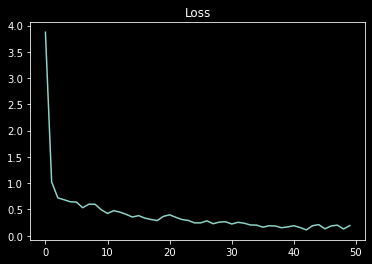

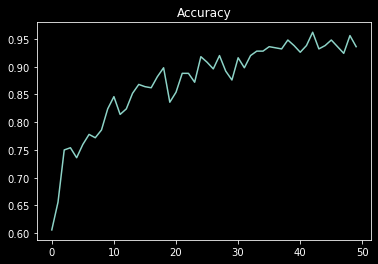

In [12]:
plt.plot(rec_losses)
plt.title("Loss")
plt.show()
plt.plot(rec_acc)
plt.title("Accuracy")
plt.show()

In [16]:
with torch.no_grad():
    encoder.eval()
    batch, id2cls = sample_data(num_way, num_spt, test_labels, device, num_qry)
    loss, logits, _ = get_loss(encoder, batch, 5, 4, 1)

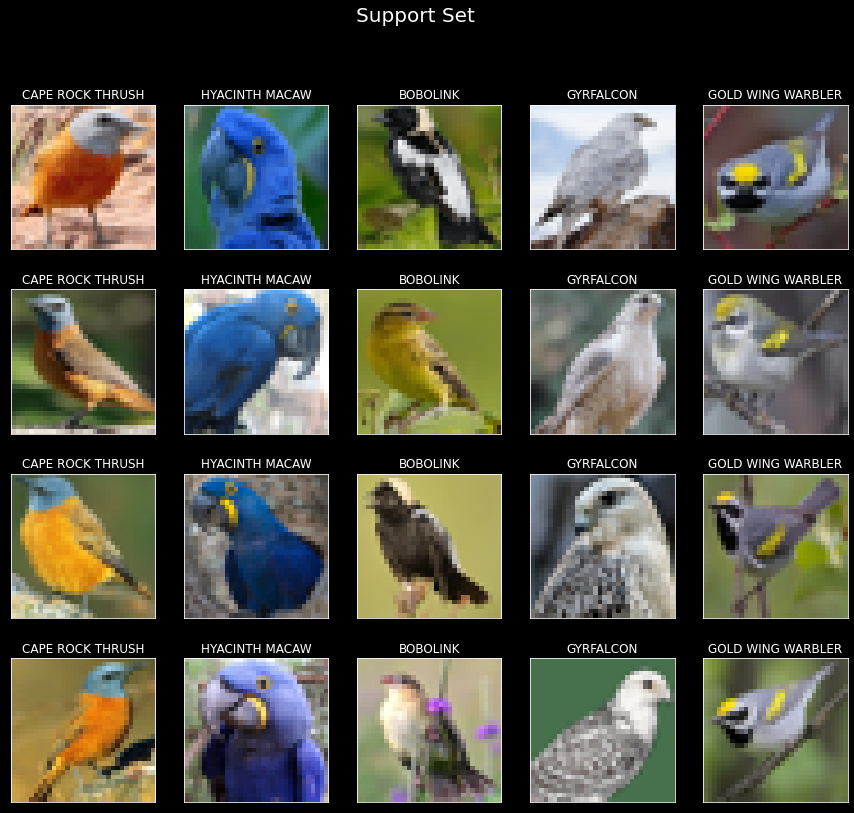

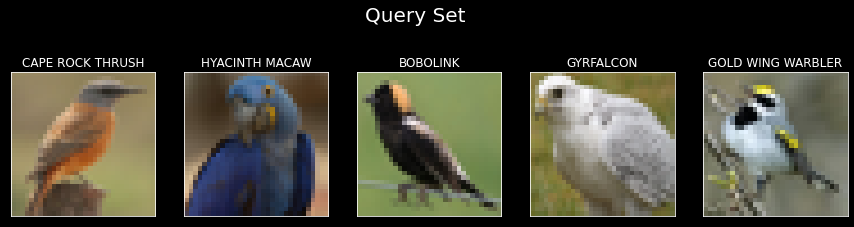

In [17]:
visualize_batch(*batch, id2cls)

In [18]:
[id2cls[i] for i in logits.argmax(axis=-1)]

['CAPE ROCK THRUSH',
 'HYACINTH MACAW',
 'BOBOLINK',
 'GYRFALCON',
 'GOLD WING WARBLER']